In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
    
import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import grad, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value

from pu.pu_dynamics import *
from pu.load_data import *

import arviz as az
import seaborn as sns

sns.set_theme(palette="pastel")


import dill

%load_ext autoreload
%autoreload 2

az.style.use(["arviz-white", "arviz-royish"],)

/Users/vivekdharmangadansree/opt/miniconda3/envs/PUNumpyro/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load saved data
data_path = "../data/" #Location where all data is stored
with open(data_path+'SVIdata.pkl', 'rb') as f:
    input_dict = dill.load(f)

dat = input_dict['dat']
ids = input_dict['ids']
loss = input_dict['loss']
model = input_dict['model']
auto_guide= input_dict['auto_guide']
params = input_dict['params']
posterior_samples = input_dict['posterior_samples']
svi_samples = input_dict['svi_samples']

init_conds = posterior_samples['v0']

# FIX ME!!
#Clear out some stuff from posterior parameter samples dict (artifacts from the choice of SVI guide) that will mess with Arviz posterior plot
try:
    del posterior_samples['v0']
except:
    pass
try:
    del posterior_samples['_auto_latent']
except:
    pass
try:
    del posterior_samples['auto_factor']
except:
    pass
try:
    del posterior_samples['auto_momentum']
except:
    pass
try:
    del posterior_samples['auto_z_0']
except:
    pass

/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_40363/2141709632.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


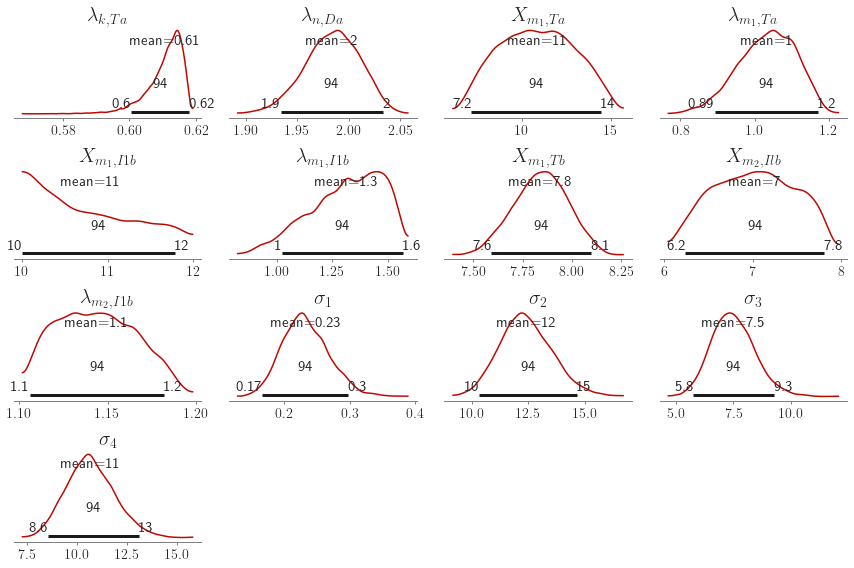

In [6]:
#posterior model parameter distributions
param_names =["lkTa", "lnDa", "Tahf", "lm1Ta", "I1bhfm1", "lm1I1b", "Tbhfm1", "I1bhfm2", "lm2I1b", "sig1", "sig2", "sig3", "sig4"]
paramprint_names = (r"$\lambda_{k,Ta}$", r"$\lambda_{n,Da}$", r"$X_{m_1,Ta}$", r"$\lambda_{m_1,Ta}$", r"$X_{m_1,I1b}$", r"$\lambda_{m_1,I1b}$", r"$X_{m_1,Tb}$", r"$X_{m_2,Ilb}$", r"$\lambda_{m_2,I1b}$",
                    r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$")


axes = az.plot_posterior(posterior_samples,var_names=param_names, grid=(4,4),figsize=(12,8))

axf = axes.flatten()
for i in range(len(param_names)):
    axf[i].set_title(paramprint_names[i],fontsize=20)

plt.tight_layout()
plt.savefig(data_path+"PosteriorParameters",dpi=300)
plt.show()

/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_40363/3899657687.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


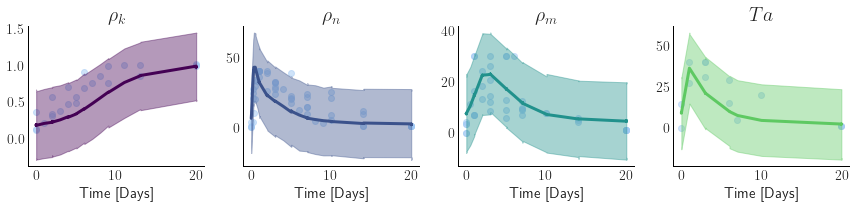

In [7]:
species = ("y_rhok", "y_rhon",  "y_rhom", "y_ta")
species_printname = (r"$\rho_{k}$", r"$\rho_{n}$", r"$\rho_{m}$", r"$Ta$")

timel = jnp.linspace(0,480,480)

cmap2 = matplotlib.cm.get_cmap('viridis', 5)

fig, ax = plt.subplots(1,4,figsize=(12,3))
axef = ax.flatten()

for i in range(len(species)):
    vals  = svi_samples[species[i]]
    mu = jnp.mean(vals, axis=0)
    pi = jnp.percentile(vals, jnp.array([2.5,97.5]), axis=0)
    axef[i].scatter(dat[i][:,0],dat[i][:,2],color = 'b',alpha=0.5)
    axef[i].plot(timel[ids[i]]/24., mu, color = cmap2(i) ,lw = 3.0)
    axef[i].fill_between(timel[ids[i]]/24., pi[0,:], pi[1,:], color = cmap2(i),alpha=0.4)
    axef[i].set_title(species_printname[i], fontsize=20)
    axef[i].set_xlabel("Time [Days]")
    
plt.tight_layout()
plt.savefig(data_path+"PosteriorDynamics",dpi=300)
plt.show()

In [8]:
az.summary(posterior_samples,var_names=param_names)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lkTa,0.611,0.006,0.600,0.618,0.000,0.000,5008.0,4654.0,NaN
lnDa,1.984,0.027,1.934,2.033,0.000,0.000,4964.0,4855.0,NaN
Tahf,10.857,2.076,7.180,14.455,0.031,0.023,4275.0,3778.0,NaN
lm1Ta,1.033,0.077,0.892,1.170,0.001,0.001,4950.0,4783.0,NaN
I1bhfm1,10.792,0.569,10.004,11.780,0.008,0.006,4774.0,4782.0,NaN
lm1I1b,1.313,0.162,1.023,1.569,0.002,0.002,4627.0,4773.0,NaN
Tbhfm1,7.843,0.136,7.592,8.097,0.002,0.001,4936.0,4456.0,NaN
I1bhfm2,7.018,0.454,6.241,7.808,0.006,0.005,4914.0,4983.0,NaN
lm2I1b,1.144,0.022,1.106,1.182,0.000,0.000,4866.0,4184.0,NaN
sig1,0.233,0.036,0.166,0.298,0.001,0.000,4485.0,4465.0,NaN


/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_40363/2007938730.py:16: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


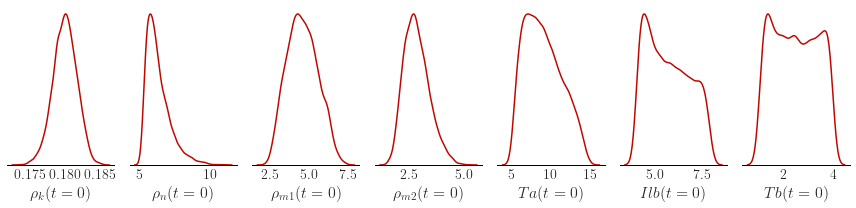

In [20]:
# Posterior for initial conditions
init_names = (r"$\rho_k (t=0)$", r"$\rho_n (t=0)$", r"$\rho_{m1} (t=0)$", r"$\rho_{m2} (t=0)$", r"$Ta (t=0)$", r"$Ilb (t=0)$", r"$Tb (t=0)$")
not_init = [4,8,9,10,11]

fig, ax = plt.subplots(1,7,figsize=(12,3))
j=0
for i in range(init_conds.shape[1]):
    if i not in(not_init):
        sns.kdeplot(init_conds[:,i],ax=ax[j])
        ax[j].set_xlabel(init_names[j],fontsize=16)
        ax[j].get_yaxis().set_visible(False)
        ax[j].spines['left'].set_visible(False)
        j+=1
        

plt.tight_layout()
plt.savefig(data_path+"PosteriorInitialConditions",dpi=300)



/var/folders/nc/j50yglgj73n8drvvbjqxczw40000gn/T/ipykernel_40363/1410864043.py:6: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


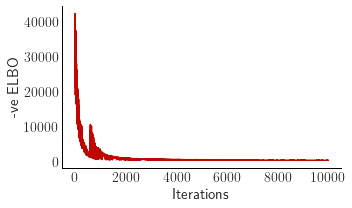

In [27]:
#ELBO Convergence
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(loss[:])
ax.set_ylabel(r"-ve ELBO")
ax.set_xlabel(r"Iterations")
plt.tight_layout()
plt.savefig(data_path+"ELBO",dpi=300)
